# <center>  **Classical quantum optimization** <center>

## **Packages**

In [3]:
from variational_algorithms.tensor_networks.tn_algorithms import Pretraining
from variational_algorithms.ansatz import QAOAAnsatz
from variational_algorithms.algorithm import VQE, QAOA
from variational_algorithms.sampler import Sampler
from variational_algorithms.optimizer import CMA_ES
from variational_algorithms.use_cases.maxcut.instances import MaxCut_Instance
from variational_algorithms.use_cases.maxcut.cost_function import MaxCut_CostFunction
from variational_algorithms.use_cases.TSP.cost_function import TSP_CostFunction
from variational_algorithms.use_cases.TSP.instances import TSP_Instance
from variational_algorithms.logger import Logger
from variational_algorithms.tensor_networks.tensor_networks import TensorOperations

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **MPO Time Evolution for QAOA**

In [5]:
n_nodes = 14

instance_max_cut = MaxCut_Instance(n_nodes)
instance_max_cut.random_erdos_renyi()

cost_function_max_cut = MaxCut_CostFunction(instance_max_cut)

n_qubits = cost_function_max_cut.num_bin_vars

exact_solution = float(instance_max_cut.brute_force()[0][2])

print('Exact solution:', exact_solution)

Exact solution: -29.0


In [ ]:
pre = Pretraining(ham = cost_function_max_cut.total_hamiltonian,
                  n_qubits = n_qubits,
                  chi_mpo = 64,
                  fidelity_mps = 1.0,
                  sweeps_mps = 100,
                  init_layers_mps = 1,
                  layers_su4 = 1,
                  connectivity_su4 = 'Linear'
                  )

pretraining_tevo = pre.time_evolution_pretraining(n_steps = 20,
                                                  dt = 0.01,
                                                  order = 2, 
                                                  init_mps = None,
                                                  metrics = True)

print(pretraining_tevo)

-0.5954811745655867


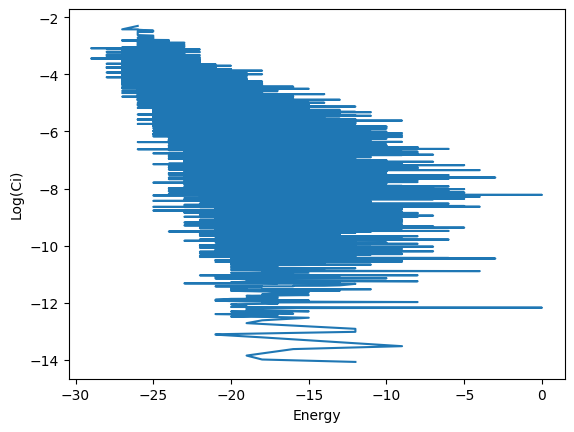

In [9]:
probs_list = []
for i in range(2**n_qubits):
    sol_string = bin(i)[2:].zfill(n_qubits)
    prob = abs(TensorOperations(pre.final_mps.tensors).proyection_state(sol_string))**2
    probs_list.append((sol_string, prob))

probs_list = sorted(probs_list, key=lambda tup: tup[1], reverse=True)

energy_x_list = []
pb_log_y_list = []
for i in range(len(probs_list)):
    
    energy_x_list.append(cost_function_max_cut.check_cost_binary(str(probs_list[i][0])))
    pb_log_y_list.append(np.log(np.sqrt(probs_list[i][1])))
    
coeficiente_pearson, valor_p = pearsonr(energy_x_list, pb_log_y_list)

print(coeficiente_pearson)


plt.plot(energy_x_list, pb_log_y_list)
plt.xlabel('Energy')
plt.ylabel('Log(Ci)')
plt.show()

In [ ]:
optimizer = CMA_ES(max_eval = 10000)
sampler = Sampler()


regular_qaoa_ansatz = QAOAAnsatz(n_qubits=n_qubits, layers=8, 
                                 costfunction=cost_function_max_cut, 
                                 ini_circuit = pretraining_tevo.circuit_mps)


qaoa_tsp = QAOA(regular_qaoa_ansatz, cost_function_max_cut, instance_max_cut, optimizer, sampler, n_shots=2000, logger = logger)

solution2_tsp = qaoa_tsp.solve()

# **Performance DMRG-VQE Classic**

In [19]:
n_nodes = 14

instance_max_cut = MaxCut_Instance(n_nodes)

#instance_max_cut.random_erdos_renyi()

instance_max_cut.import_from_file('logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_instance_n_14')

#instance_max_cut.export_to_file('logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_instance_n_14')

cost_function_max_cut = MaxCut_CostFunction(instance_max_cut)


n_qubits = cost_function_max_cut.num_bin_vars

exact_solution = float(instance_max_cut.brute_force()[0][2])

print('Exact solution:', exact_solution)

Exact solution: -38.0


In [21]:
backend = PennyLaneBackend()
pre = Pretraining(circ_class = PennyLaneQuantumCircuit, 
                  ham = cost_function_max_cut.total_hamiltonian,
                  n_qubits = n_qubits,
                  chi_mpo = 2,
                  fidelity_mps = 1.0,
                  sweeps_mps = 50,
                  init_layers_mps = 2,
                  layers_su4 = 1,
                  connectivity_su4 = 'Linear'
                  )

pretraining_dmrg = pre.dmrg_pretraining(metrics= True, prep_state_dmrg = 'One_state', sweeps_dmrg = 2, lanczos_krydim = 4)

print(pretraining_dmrg)

Results:
effective_dimension: [1.999488131038454]
coherence: [0.9998153271549207] 
fun: -35.99999999999999 
fun_history: [-28.999999999999996, -29.52678360424658, -29.999983287234123, -30.499999893705322, -31.499987789185028, -31.999999890728496, -32.49999992709296, -32.999987858942696, -34.49998781960505, -34.9999878196364, -35.49997571806061, -35.49997571806091, -35.9999757207338, -35.99997572333275, -35.99997572507268, -35.99997572521139, -35.999975725211385, -35.99997572521139, -35.99997572521465, -35.99997572521616, -35.99997572521963, -35.99997572522682, -35.99997573078708, -35.99997580410192, -35.99999999974906, -35.99999999974906, -35.99999999974906, -35.999999999749065, -35.99999999974997, -35.999999999750266, -35.999999999750266, -35.99999999975027, -35.99999999975027, -35.99999999975027, -35.99999999975033, -35.99999999975032, -35.9999999997508, -36.00000000000001, -36.00000000000001, -36.00000000000001, -36.000000000000014, -36.00000000000001, -36.0, -36.0, -35.999999999999

In [23]:
ruta_dmrg= f'logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_dmrg_vqe_linear.json'

datos_dmrg = {
    "energy_dmrg": pretraining_dmrg.fun_history,
    "exact_energy": exact_solution
}

json_datos_dmrg = json.dumps(datos_dmrg, indent=2)

with open(ruta_dmrg, 'w') as archivo:
    archivo.write(json_datos_dmrg)

In [24]:
ansatz_tevo = CustomAnsatz(init_circuit = pretraining_dmrg.circuit_mps, circuit = pretraining_dmrg.circuit_su4)

ini_params = ansatz_tevo.init_params

optimizer = CMA_ES(max_eval = 1000)


sampler = Sampler()

ruta_vqe = f'case_0_max_cut_dmrg_vqe_quantum_linear.json'
logger = Logger(folder_path="logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe", file_name= ruta_vqe)

vqe = VQE(ansatz_tevo, backend, cost_function_max_cut, instance_max_cut, optimizer, sampler, logger = logger)
result_vqe_tevo = vqe.solve(ini_params)

(9_w,19)-aCMA-ES (mu_w=5.6,w_1=29%) in dimension 195 (seed=791550, Mon Aug 26 11:34:54 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     19 -3.600000000000000e+01 1.0e+00 9.74e-03  1e-02  1e-02 0:09.0
    2     38 -3.600000000000000e+01 1.0e+00 9.51e-03  1e-02  1e-02 0:18.2
    3     57 -3.600000000000000e+01 1.0e+00 9.31e-03  9e-03  9e-03 0:27.2
    4     76 -3.599800000000000e+01 1.0e+00 9.13e-03  9e-03  9e-03 0:36.1
    5     95 -3.600000000000000e+01 1.0e+00 8.98e-03  9e-03  9e-03 0:45.2
    6    114 -3.600100000000000e+01 1.0e+00 8.85e-03  9e-03  9e-03 0:54.1
    7    133 -3.600000000000000e+01 1.0e+00 8.73e-03  9e-03  9e-03 1:03.3
    8    152 -3.600000000000000e+01 1.0e+00 8.62e-03  9e-03  9e-03 1:12.1
    9    171 -3.600000000000000e+01 1.0e+00 8.52e-03  9e-03  9e-03 1:21.0
   10    190 -3.599900000000000e+01 1.0e+00 8.43e-03  8e-03  8e-03 1:37.6
   11    209 -3.600000000000000e+01 1.0e+00 8.34e-03  8e-03  8e-03 1:54.4
   12    228 -3.59980

In [57]:
N = 3
instance_tsp = TSP_Instance(N)
instance_tsp.random_uniform_distances()

#instance_tsp.export_to_file('logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_instance_n_9')


instance_tsp.import_from_file('logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_instance_n_9')

cost_function_tsp = TSP_CostFunction(instance_tsp, lagrange_multiplier=10)
n_qubits = cost_function_tsp.num_bin_vars

print(n_qubits)

energy_sol = instance_tsp.brute_force()[0][1]
print("energy_sol", energy_sol)

9
energy_sol 1.0155895885518815


In [58]:
backend = PennyLaneBackend()
pre = Pretraining(circ_class = PennyLaneQuantumCircuit, 
                  ham = cost_function_tsp.total_hamiltonian,
                  n_qubits = n_qubits,
                  chi_mpo = 2,
                  fidelity_mps = 1.0,
                  sweeps_mps = 50,
                  init_layers_mps = 2,
                  layers_su4 = 1,
                  connectivity_su4 = 'Linear'
                  )

pretraining_dmrg = pre.dmrg_pretraining(metrics= True, prep_state_dmrg = 'One_state', sweeps_dmrg = 3, lanczos_krydim = 4)

print(pretraining_dmrg)

Results:
effective_dimension: [1.0]
coherence: [-0.0] 
fun: 1.5792698603718236 
fun_history: [30.829753275943453, 45.64873079230716, 37.071598509866476, 30.897965823627953, 26.243508062560636, 21.533714341573294, 20.455771309372146, 20.225368459599345, 12.381614168523363, 12.381254524422346, 12.381254522168454, 6.907656387202927, 1.5907299347473582, 1.5794619535379653, 1.5793827205768878, 1.579382720576909, 1.5793827205768949, 1.5793827205768665, 1.5793827205768878, 1.5793827111169207, 1.5792698635299658, 1.5792698635166218, 1.579269860373401, 1.5792698603733868, 1.5792698603734152, 1.5792698603733797, 1.579269860373337, 1.5792698603733157, 1.5792698603718591, 1.5792698603719018, 1.5792698603718875, 1.5792698603719018, 1.5792698603719018, 1.5792698603718875, 1.5792698603719018, 1.579269860371916, 1.579269860371916, 1.5792698603718947, 1.5792698603718804, 1.5792698603718591, 1.5792698603719089, 1.5792698603719018, 1.5792698603718804, 1.5792698603719018, 1.5792698603719018, 1.57926986037

In [59]:
ruta_dmrg= f'logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_dmrg_vqe_linear.json'

datos_dmrg = {
    "energy_dmrg": pretraining_dmrg.fun_history,
    "exact_energy": energy_sol
}

json_datos_dmrg = json.dumps(datos_dmrg, indent=2)

with open(ruta_dmrg, 'w') as archivo:
    archivo.write(json_datos_dmrg)

In [60]:
ansatz_tevo = CustomAnsatz(init_circuit = pretraining_dmrg.circuit_mps, circuit = pretraining_dmrg.circuit_su4)

ini_params = ansatz_tevo.init_params

optimizer = CMA_ES(max_eval = 1000)


sampler = Sampler()

ruta_vqe = f'case_0_tsp_dmrg_vqe_quantum_linear.json'
logger = Logger(folder_path="logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe", file_name= ruta_vqe)

vqe = VQE(ansatz_tevo, backend, cost_function_tsp, instance_tsp, optimizer, sampler, logger = logger)
result_vqe_tevo = vqe.solve(ini_params)

(9_w,18)-aCMA-ES (mu_w=5.4,w_1=30%) in dimension 120 (seed=816396, Mon Aug 26 16:48:51 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     18 1.579269860371853e+00 1.0e+00 9.64e-03  1e-02  1e-02 0:00.7
    2     36 1.579269860371853e+00 1.0e+00 9.36e-03  9e-03  9e-03 0:01.6
    3     54 1.579269860371853e+00 1.0e+00 9.12e-03  9e-03  9e-03 0:02.6
    7    126 1.579269860371853e+00 1.0e+00 8.51e-03  8e-03  9e-03 0:05.7
   13    234 1.579269860371853e+00 1.0e+00 7.81e-03  8e-03  8e-03 0:10.5
   20    360 1.579269860371853e+00 1.1e+00 7.35e-03  7e-03  7e-03 0:15.9
   28    504 1.579269860371853e+00 1.1e+00 7.22e-03  7e-03  7e-03 0:22.4
   37    666 1.579269860371853e+00 1.1e+00 7.14e-03  7e-03  7e-03 0:29.8
   47    846 1.579269860371853e+00 1.2e+00 6.86e-03  7e-03  7e-03 0:38.1
   56   1008 1.579269860371853e+00 1.2e+00 6.77e-03  7e-03  7e-03 0:45.4
termination on maxfevals=1000 (Mon Aug 26 16:49:36 2024)
final/bestever f-value = 1.658189e+00 1.579270e+